In [57]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings
import time
start_time = time.time()
warnings.filterwarnings('ignore')

# load datasets
train = pd.read_csv('E:\\clean2_data.csv', parse_dates=['order_date'], index_col=['order_date'])
test = pd.read_csv('E:\\your_data_with_predictions.csv', parse_dates=['order_date'], index_col=['order_date'])

In [58]:
def sales_prediction():

    # Expand dataframe with more useful columns
    def expand_df(dataframe):
        dataframe['day'] = dataframe.index.day
        dataframe['month'] = dataframe.index.month
        dataframe['year'] = dataframe.index.year
        dataframe['dayofweek'] = dataframe.index.dayofweek
        return dataframe

    data = expand_df(train)
    
    # Only data 2016 and after is used
    new_data = data.loc[data.year >= 2016]
    grand_avg = new_data.ord_qty.mean()

    # Day of week - Item Look up table
    dow_item_table = pd.pivot_table(new_data, index='dayofweek', columns='item_code', values='ord_qty', aggfunc=np.mean)
    # Month pattern
    month_table = pd.pivot_table(new_data, index='month', values='ord_qty', aggfunc=np.mean) / grand_avg
    # Store pattern
    store_table = pd.pivot_table(new_data, index='sales_region_code', values='ord_qty', aggfunc=np.mean) / grand_avg
    # weighted growth rate
    year_table = pd.pivot_table(data, index='year', values='ord_qty', aggfunc=np.mean) / grand_avg
    years = np.arange(2015, 2020)
    annual_growth = np.poly1d(np.polyfit(years[:-1], year_table.values.squeeze(), 2, w=np.exp((years - 2019) / 10)[:-1]))

    pred_sales = []
    for _, row in test.iterrows():
        dow, month, year = row.name.dayofweek, row.name.month, row.name.year
        item, store = row['item_code'], row['sales_region_code']
        base_sales = dow_item_table.at[dow, item]
        mul = month_table.at[month, 'ord_qty'] * store_table.loc[store, 'ord_qty']
        pred = base_sales * mul * annual_growth(year)
        if np.isnan(pred):
#             print('Warning: NaN value detected for input:', row)
            pred_sales.append(0)
        else:
            pred_sales.append(int(np.round(pred, 0)))       
    return pred_sales

# extending train dataset with test dataset by sale prediction for 2018
test['ord_qty'] = sales_prediction()
train = train.loc[train.index.year >= 2015, :] # use only data after 2015
df = pd.concat([train, test], sort=False)
df.reset_index(inplace=True)

### Generating Datetime Related Features :

In [59]:
# create feature from datetime columns
def create_date_features(dataframe):
    dataframe['month'] = dataframe.order_date.dt.month
    dataframe['day_of_month'] = dataframe.order_date.dt.day
    dataframe['day_of_year'] = dataframe.order_date.dt.dayofyear
    dataframe['week_of_year'] = dataframe.order_date.dt.weekofyear
    dataframe['day_of_week'] = dataframe.order_date.dt.dayofweek + 1
    dataframe['year'] = dataframe.order_date.dt.year
    dataframe['is_wknd'] = dataframe.order_date.dt.weekday // 4
    dataframe['is_month_start'] = dataframe.order_date.dt.is_month_start.astype(int)
    dataframe['is_month_end'] = dataframe.order_date.dt.is_month_end.astype(int)
    dataframe['quarter'] = dataframe.order_date.dt.quarter
    dataframe['week_block_num'] = [int(x) for x in np.floor((dataframe.order_date - pd.to_datetime('2012-12-31')).dt.days / 7) + 1]
    dataframe['quarter_block_num'] = (dataframe['year'] - 2013) * 4 + dataframe['quarter']
    dataframe['week_of_month'] = dataframe['week_of_year'].values // 4.35
    return dataframe
                                                                                                                             
                                                                                                                                              
df = create_date_features(df)                                                                                                                 
                                                                                                                                              
# day labeling features                                                                       
df['is_Mon'] = np.where(df['day_of_week'] == 1, 1, 0)                                                                                            
df['is_Tue'] = np.where(df['day_of_week'] == 2, 1, 0)                                                                                         
df['is_Wed'] = np.where(df['day_of_week'] == 3, 1, 0)                                                                                         
df['is_Thu'] = np.where(df['day_of_week'] == 4, 1, 0)                                                                                         
df['is_Fri'] = np.where(df['day_of_week'] == 5, 1, 0)                                                                                         
df['is_Sat'] = np.where(df['day_of_week'] == 6, 1, 0)                                                                                         
df['is_Sun'] = np.where(df['day_of_week'] == 7, 1, 0)

# df.to_csv('E:\\3.csv')

### Generating Sale Aggregation Based Feature :

In [60]:
# generating some new features from aggregation of sales within different time frames
feat_list = ['day_of_week', 'week_of_month', 'week_of_year', 'month', 'quarter', 'is_wknd'] + ['day_of_week', 'week_of_month']
shift_values = [0, 0, 0, 0, 0, 0, 12, 12]
for time_item, shift_val in zip(feat_list, shift_values):
    grouped_df = df.groupby(['sales_region_code', 'item_code', time_item])['ord_qty'].expanding().mean().shift(shift_val).bfill().reset_index()
    grouped_df.columns = ['sales_region_code', 'item_code', time_item, 'order_date', time_item + f'_ex_avg_sale{str(shift_val)}']
    grouped_df = grouped_df.sort_values(by=['item_code', 'sales_region_code', 'order_date'])
    df[time_item + f'_ex_avg_sale{str(shift_val)}'] = grouped_df[time_item + f'_ex_avg_sale{str(shift_val)}'].values

### Generating Smoothing based Features with Lag/Shift, Rolling Mean and Exponentially Weighted Techniques :

In [61]:
# make sure dataset sorted with original order                                                  
df.sort_values(by=['item_code', 'sales_region_code', 'order_date'], axis=0, inplace=True) 


#generating some noise                                                                   
def random_noise(dataframe):                                                                                                                  
    return np.random.normal(scale=0.01, size=(len(dataframe),))    


# Lag/Shifted Features                                                                                                                                                      
# generating laggy features with different time windows                                                                                                                                 
def lag_features(dataframe, lags):                                                                                                            
    dataframe = dataframe.copy()                                                                                                              
    for lag in lags:                                                                                                                          
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["item_code", "sales_region_code"])['ord_qty'].transform(lambda x: x.shift(lag)) + random_noise(dataframe)                                                                                 
    return dataframe                                                                                                                          
                                                                                                                                              
                                                                                                                                              
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])                                                                       
                                                                                                                                 

    
# Rolling Mean Features                                                                                                                       
def roll_mean_features(dataframe, windows):                                                                                                   
    dataframe = dataframe.copy()                                                                                                              
    for window in windows:                                                                                                                    
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["item_code", "sales_region_code"])['ord_qty'].\
        transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)            
    return dataframe                                                                                                                          
                                                                                                                                              
                                                          
df = roll_mean_features(df, [91, 182, 365, 546, 730])                                                                                         
                                                                                                                                              

    
# Exponentially Weighted Mean Features                                                                                                        
def ewm_features(dataframe, alphas, lags):                                                                                                    
    dataframe = dataframe.copy()                                                                                                              
    for alpha in alphas:                                                                                                                      
        for lag in lags:                                                                                                                      
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
            dataframe.groupby(["item_code", "sales_region_code"])['ord_qty'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())                       
    return dataframe                                                                                                                          
                                                                                                                                              
                                                                                                                                              
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]                                             
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]
df = ewm_features(df, alphas, lags)

### Final step for Data preparation :

End of feature engineering and data preparation.
It takes 56 sec.
---=> final dataframe has 971 features <=---


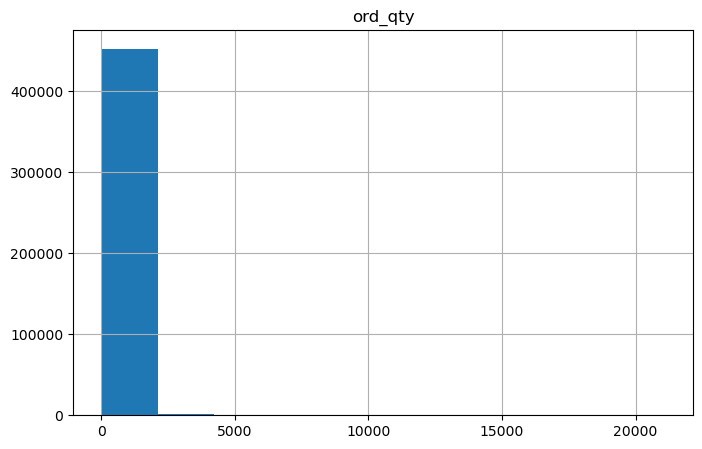

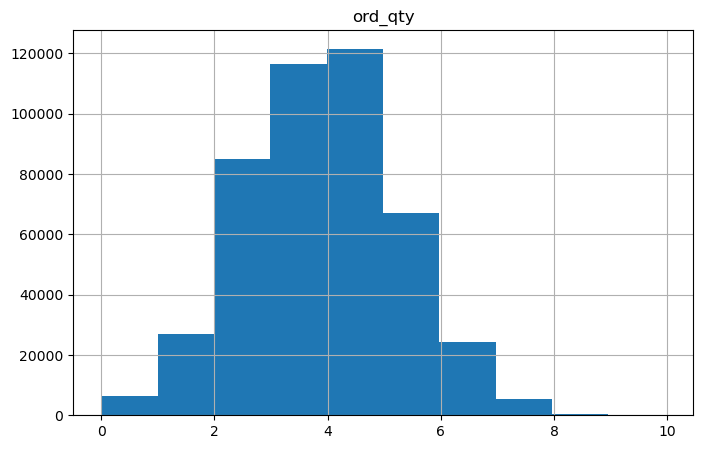

In [62]:
# One-Hot Encoding                                                                                                                            
df_dum = pd.get_dummies(df[['sales_region_code', 'item_code', 'day_of_week', 'month', ]], columns=['sales_region_code', 'item_code', 'day_of_week', 'month', ], dummy_na=True)  
df = pd.concat([df, df_dum], axis=1)                                                                                                          
df.hist('ord_qty',figsize=(8,5))

# convert to logarithmic scale                                                                                                           
df['ord_qty'] = np.log1p(df["ord_qty"].values)
df.hist('ord_qty',figsize=(8,5))

print(f'End of feature engineering and data preparation.') 
print(f'It takes {int(time.time()-start_time)} sec.')
print(f'---=> final dataframe has {df.shape[1]} features <=---') 

### LightGM Model with Final Dataset :

Final model calculation starts..
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17531
[LightGBM] [Info] Number of data points in the train set: 131050, number of used features: 545
[LightGBM] [Info] Start training from score 4.174387
[1]	Train's l1: 1.18136	Test's l1: 1.26695
[2]	Train's l1: 1.16346	Test's l1: 1.25194
[3]	Train's l1: 1.14716	Test's l1: 1.23581
[4]	Train's l1: 1.13208	Test's l1: 1.22402
[5]	Train's l1: 1.11816	Test's l1: 1.21271
[6]	Train's l1: 1.10541	Test's l1: 1.19975
[7]	Train's l1: 1.09362	Test's l1: 1.18951
[8]	Train's l1: 1.08282	Test's l1: 1.1788
[9]	Train's l1: 1.07274	Test's l1: 1.16802
[10]	Train's l1: 1.06352	Test's l1: 1.15885
[11]	Train's l1: 1.05486	Test's l1: 1.15091
[12]	Train's l1: 1.04705	Test's l1: 1.14548
[13]	Train's l1: 1.03986	Test's l1: 1

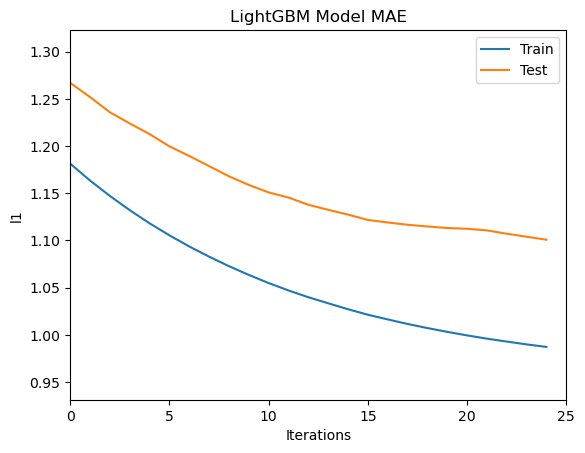

In [102]:
# MODEL VALIDATION
start_time = time.time()
print("Final model calculation starts..")                                                                
cols = [col for col in df.columns if col not in ['date','order_date','id', "ord_qty", "year"]]   

# train = df.loc[~df.ord_qty.isna()]
train = df.loc[(df["order_date"] < "2018-01-01"), :]
X_train, Y_train = train[cols], train['ord_qty']                                                                                                                         
                                                                                                                                              
# test = df.loc[df.id.notnull()]
test = df.loc[(df["order_date"] >= "2018-01-01") & (df["order_date"] < "2018-04-01"), :]
# X_test, = test[cols]                                                                                                                           
X_test,Y_test = test[cols], test['ord_qty']                                                                                                                                              
iteration = 25 #训练次数

lgb_params = {                                                                                                                            
        'nthread': -1,
        'metric': 'mae',
        'boosting_type': 'gbdt',    
        'max_depth': 7,
        'num_leaves': 28,   
        'task': 'train',                                                                                                                      
        'objective': 'regression_l1',                                                                                                         
        'learning_rate': 0.05,                                                                                                                
        'feature_fraction': 0.9,                                                                                                              
        'bagging_fraction': 0.8,                                                                                                              
        'bagging_freq': 5,                                                                                                                    
        'lambda_l1': 0.06,                                                                                                                    
        'lambda_l2': 0.05,                                                                                                                    
        'verbose': 1,     }                                                                                                                                                                                                                                                                        
# LightGBM dataset                                                                                                                        
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)  
lgbtest = lgb.Dataset(data=X_test, label=Y_test, feature_name=cols)
# final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=iteration,)
# test_preds = final_model.predict(X_test, num_iteration=iteration)

evals_result = {}
final_model = lgb.train(
    params=lgb_params, 
    train_set=lgbtrain_all, 
    num_boost_round=iteration,
    valid_sets=[lgbtrain_all, lgbtest],
    valid_names=['Train', 'Test'],
    callbacks=[
        lgb.callback.print_evaluation(period=100),  # 每隔 100 轮输出一次指标
        lgb.callback.record_evaluation(evals_result)  # 将指标记录到字典中
    ]
)
test_preds = final_model.predict(X_test, num_iteration=iteration)
# 可视化训练过程中的指标
ax = lgb.plot_metric(evals_result, metric='l1')
plt.title('LightGBM Model MAE')
plt.grid(False)
plt.show()

In [103]:
from sklearn.metrics import explained_variance_score,mean_absolute_error, mean_squared_error, r2_score

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_pred, y_true):
    smape_val = smape(np.expm1(preds), np.expm1(y_true))
    return 'SMAPE', smape_val, False

smape_val = smape(np.expm1(test_preds), np.expm1(Y_test))
explained_variance = explained_variance_score(Y_test, test_preds)
mae_val = mae(Y_test, test_preds)
rmse_val = np.sqrt(mean_squared_error(Y_test, test_preds))
r2_val = r2_score(Y_test, test_preds)

# Print evaluation metrics results
print("\nMODEL EVALUATION:")

print("SMAPE: {:.4f}".format(smape_val))
print("Explained variance: {:.4f}".format(explained_variance) )
print("Mean Absolute Error (MAE): {:.4f}".format(mae_val))
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse_val))
print("R2 Score: {:.4f}".format(r2_val))

print(f'The model calculation is done in {int(time.time()-start_time)} sec.')   


MODEL EVALUATION:
SMAPE: 92.4529
Explained variance: 0.2467
Mean Absolute Error (MAE): 1.1008
Root Mean Squared Error (RMSE): 1.3333
R2 Score: 0.2354
The model calculation is done in 6 sec.


In [104]:
importances = final_model.feature_importance()
feature_names = final_model.feature_name()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance.head(25))

                        Feature  Importance
41           sales_roll_mean_91         129
13               week_block_num         122
43          sales_roll_mean_365          54
0             sales_region_code          45
6                   day_of_year          41
42          sales_roll_mean_182          30
960                   month_7.0          20
44          sales_roll_mean_546          18
1                     item_code          18
4                     dayofweek          18
7                  week_of_year          14
963                  month_10.0          10
45          sales_roll_mean_730          10
2                           day          10
878           item_code_21902.0           9
87   sales_ewm_alpha_05_lag_270           7
959                   month_6.0           7
632           item_code_21271.0           7
779           item_code_21644.0           6
320           item_code_20545.0           6
94      sales_region_code_105.0           6
31                 sales_lag_91 

<Figure size 3000x1000 with 0 Axes>

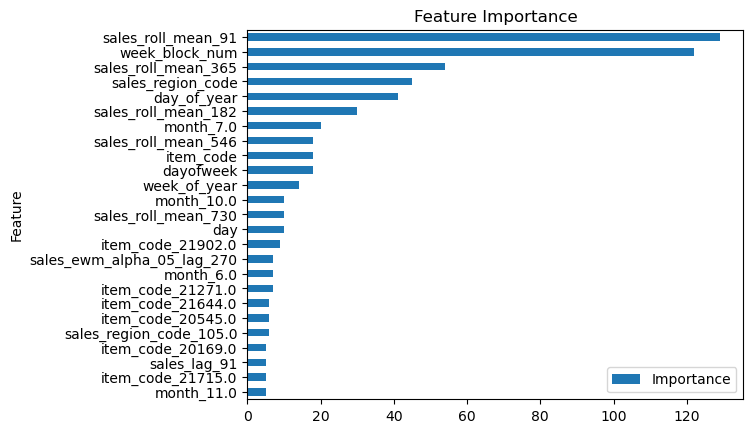

In [105]:
plt.figure(figsize=(30, 10))
feature_importance.head(25).sort_values('Importance').plot(kind='barh', x='Feature', y='Importance', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

### Generating the Submission File :

In [ ]:
# create submission file
p_data = df.loc[df.id.notnull()]
pre_d = p_data[cols]
pres_d = final_model.predict(pre_d, num_iteration=iteration)
submission = pd.DataFrame({ 'id': [*range(196830)], 'ord_qty': np.round(np.expm1(pres_d),0) }) # turn back to normal scale
submission['ord_qty'] = submission.ord_qty.astype(int)
submission.to_csv('submission_lgbm.csv', index=False)
print(f'OK, Submission file is created!')